## Tutorial Outline

**In this tutorial we will demonstrate how to:**
 1. Use the new *Chempy* functions, which take the stellar birth-time as inputs
 2. Create and train a neural network to emulate the *Chempy* with birth-time as a free parameter
 3. Generate mock data-sets using *Chempy*. We will also describe the file structure needed for arbitrary input data-sets and give the mock data-sets used in the *ChempyMulti* paper analysis.
 4. Run HMC inference using *Chempy* and PyMC3
 5. Analyze the resulting posterior distributions
 
The above are based on the Phlcox & Rybizki (2019, submitted, [arXiv](https://arxiv.org/abs/1909.00812)) paper which should be cited when using this code. The *ChempyMulti* package is based on the earlier *ChempyScoring* package described in Philcox et al. 2018 ([code](https://github.com/oliverphilcox/ChempyScoring), [arXiv](https://arxiv.org/abs/1712.05686)) and on the original *Chempy* package discussed in Rybizki et al. 2017 ([code](https://github.com/jan-rybizki/Chempy), [arXiv](https://arxiv.org/abs/1702.08729))

Requirements: Before running this tutorial, the $\mathit{ChempyMulti}$ code and its dependencies (found [here](https://github.com/oliverphilcox/ChempyMulti/blob/master/requirements.txt)) must be installed.

The authors [Oliver Philcox](mailto:ohep2@alumni.cam.ac.uk) and [Jan Rybizki](mailto:rybizki@mpia.de) are happy to assist with any problems which may arise.

# 1) Using the new *Chempy* functions

The main new functionality of *Chempy* is in the ``single_timestep_chempy`` function, which returns ISM abundances for a given set of Simple Stellar Population (SSP) and Interstellar Medium (ISM) parameters as well as the stellar birth-time (i.e. simulation end-time). A number of modifications have been made to the *Chempy* code to allow for this to be a free parameter (e.g. renormalizations in the star formation rate and careful accounting for discretization effects). 

For more details on using the standard *Chempy* functions, see the *Chempy* [tutorials](https://github.com/jan-rybizki/Chempy/tree/master/tutorials).

First we'll import in the modelling parameters, as we do in the standard *Chempy* package. The ``ModelParameters`` function contains all necessary simulation parameters and is loaded in the following manner:

In [80]:
%pylab inline
import os
#os.chdir('/home/oliverphilcox/ChempyMulti/')
from Chempy.parameter import ModelParameters
a=ModelParameters()

%pylab is deprecated, use %matplotlib inline and import the required libraries.
Populating the interactive namespace from numpy and matplotlib


/Users/bguenes/miniconda3/envs/master_chempy_multi/lib/python3.12/site-packages/IPython/core/magics/pylab.py:166: UserWarning: pylab import has clobbered these variables: ['choice', 'time', 'e', 'median', 'axes']
`%matplotlib` prevents importing * from pylab and numpy
  warn("pylab import has clobbered these variables: %s"  % clobbered +


First let's see what yield tables are loaded by default.

In [81]:
print("SN 1a yield table is %s"%a.yield_table_name_1a)
print("SN II yield table is %s"%a.yield_table_name_sn2)
print("AGB yield table is %s"%a.yield_table_name_agb)

SN 1a yield table is TNG
SN II yield table is TNG_net
AGB yield table is TNG_net


So we're using yield tables appropriate for the IllustrisTNG simulation, as in the *ChempyMulti* paper. All these can be changed by altering the ``Chempy/parameter.py`` file.

Now let's check what parameters we're optimizing over;

In [82]:
for opt in a.to_optimize:
    print("Variable: %s Prior: %.2f +- %.2f"%(opt,a.priors[opt][0],a.priors[opt][1]))

Variable: high_mass_slope Prior: -2.30 +- 0.30
Variable: log10_N_0 Prior: -2.89 +- 0.30
Variable: log10_starformation_efficiency Prior: -0.30 +- 0.30
Variable: log10_sfr_scale Prior: 0.55 +- 0.10
Variable: outflow_feedback_fraction Prior: 0.50 +- 0.10


These all look as expected! Also, we'll check what elements we're tracing in the code:

In [83]:
print(a.elements_to_trace)

['C', 'Fe', 'H', 'He', 'Mg', 'N', 'Ne', 'O', 'Si']


**NB**: We need to include H here even though it's not directly used for inference. This is needed to normalize the [X/Fe] and [Fe/H] abundances.

Now let's try the new function; ``single_timestep_chempy``. The inputs are a list of variable values followed by the ``ModelParameters()``. The format of the variable list is:
- SSP Parameters (here the IMF slope ``high_mass_slope`` and the SN 1a normalization ``log10_N_0``)
- ISM Parameters (here the Star Formation Efficiency (SFE) ``log10_starformation_efficiency``, the Star Formation Rate (SFR) ``log10_sfr_scale`` and the outflow feedback fraction ``outflow_feedback_fraction``)
- Simulation end-time in Gyr (equal to the stellar birth-time)

The number of simulation time-steps is *always* equal to the number specified in the parameter file, no matter what the output time is. This is necessary to ensure good accuracy at small stellar birth times.

In [84]:
from Chempy.cem_function import single_timestep_chempy

In [85]:
# Let's create a parameter list, just using the prior parameters (specified in the p0 variable) with an end-time at 10 Gyr
parameter_list = list(a.p0)+[10.]

# Run the simulation
abundances,elements=single_timestep_chempy((parameter_list,a))

This takes $\sim 1s$ to run for a given set of parameter inputs and yield tables. In the ``abundances`` variable, we have the output [X/Fe] and [Fe/H] chemical abundances at 10 Gyr, normed to the Asplund et al. (2009) solar element fractions. The ``elements`` variable tells us what order these abundances are in.

In [86]:
print("ISM Abundances after 10 Gyr with Prior SSP and ISM Parameters")
print("-------------------------------------------------------------")
for e in range(len(elements)):
    print("%s \t %.2f dex"%(elements[e],abundances[e]))

ISM Abundances after 10 Gyr with Prior SSP and ISM Parameters
-------------------------------------------------------------
C 	 -0.05 dex
Fe 	 0.23 dex
H 	 -0.23 dex
He 	 -0.18 dex
Mg 	 0.13 dex
N 	 -0.04 dex
Ne 	 0.43 dex
O 	 0.22 dex
Si 	 0.11 dex


Using this function we can simply compute abundances as a function of time;

In [87]:
all_times = np.linspace(1.,13.8,20)
all_abundances = []

for time in all_times:
    parameter_list = list(a.p0)+[time]

    # Run the simulation
    abundances,elements=single_timestep_chempy((parameter_list,a))
    all_abundances.append(abundances)

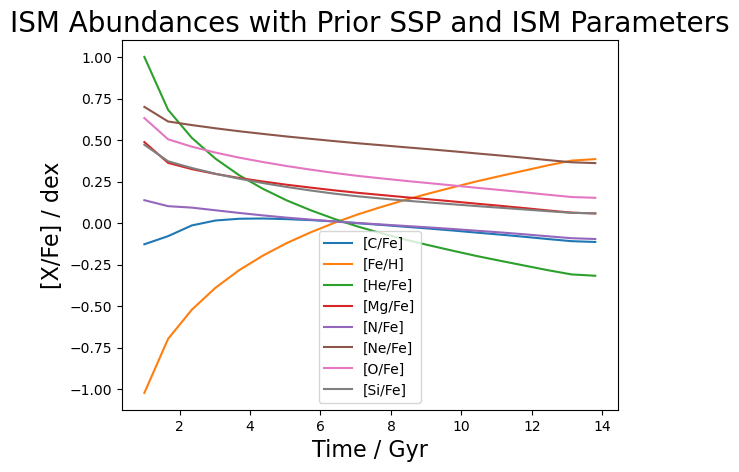

In [88]:
all_abundances = np.asarray(all_abundances)
for  e in range(len(elements)):
    if elements[e]=='H':
        continue
    elif elements[e]=='Fe':
        label='[Fe/H]'
    else:
        label='[%s/Fe]'%elements[e]
    plt.plot(all_times,all_abundances[:,e],label=label)
plt.legend()
plt.xlabel('Time / Gyr',fontsize=16)
plt.ylabel('[X/Fe] / dex', fontsize=16)
plt.title('ISM Abundances with Prior SSP and ISM Parameters',fontsize=20);

# 2) Creation and Training of the Neural Network
**Training Data**

The first step in the Multi-Star inference is to create the neural network, which is used to replace *Chempy* for faster sampling. For this we require *training data*; a large set of input parameters and output chemical abundances created by *Chempy*.

Data can be created using the ``random_training_data.py`` script. By default, this draws $N_\rm{samples}=5\times10^5$ samples from the *Chempy* priors and computes the abundances for each. To run the script locally, the location of the output file should be specified in the final line of the script. Here, we have saved the training data in the ``tutorial_data/`` directory.

This script uses the *Chempy* settings specified in the *Chempy* parameter file located at ``Chempy/parameter.py``. Full usage of this is described in the main *Chempy* tutorial. Important parameters to set are the choice of nucleosynthetic elements to track and the choice of yield tables (also discussed in the *ChempyScoring* tutorial).

Once these settings are configured, the script may be run simply on the command line:

``python random_training_data.py``

By default the code uses 16 cores for multiprocessing, or the maximum available on the machine. This may be changed in the script. This is the most computationally intensive part of the analysis, taking $\sim 100$ CPU-hours to run.

**Test Data**

To assess how well the network performs, we require an independent set of *test data*, drawn from the same distributions. This is computed as for the training data, using the ``random_test_data.py`` script (which is identical in form to the training data script). By default, we create $5\times10^4$ test data samples (and their abundances) distributed across parameter space. This requires $\sim 10$ CPU-hours to run.

**Network Creation**

Following creation of training and test data, the neural network can be created. This is done in ``scikit-learn`` using the Python code below. As discussed in the multi-star inference paper, we use a single network for eah element for better training, combined into a single sparsely connected network. Here we use 40 neurons for each network, which was found to be the optimal number for our configuration.

First we load the data;

In [89]:
# Define elements to use (matching those chosen in the Chempy script, but without H which is only used for normalization):
els = ['C','Fe','He','Mg','N','Ne','O','Si'] # TNG elements
#els = a.initial_neural_names # alternatively we can load these from the ModelParameters() class

# Load in training data created by the random_training_data.py script:
full_input = '../ChempyMulti/tutorial_data/TNG_Training_Data.npz'
dat1=np.load(full_input,mmap_mode='r')

all_els = dat1['elements'] # all elements tracked by the Chempy code
params = dat1['params'] # input Chempy parameters 
big_abun = dat1['abundances'] # output Chempy abundances

Now filter out any unneeded elements and runs that failed for some reason;

In [90]:
el_indices=np.zeros(len(els),dtype=int)
for e,el in enumerate(els):
    el_indices[e]=np.where(el==all_els)[0]
    
# Filter out unwanted elements
abun = big_abun[:,el_indices]

## Remove any bad runs
bitmap=np.ones(len(params),dtype=int)
for i,ab in enumerate(abun):
    if ab[0]==0:
        bitmap[i]=0

cut_params=params[np.where(bitmap==1)]
cut_abuns=abun[np.where(bitmap==1)]

good_index=np.where(np.isfinite(cut_abuns).all(axis=1))[0] # remove infinities
cut_params2=cut_params[good_index]
cut_abuns2=cut_abuns[good_index]
good_index2=np.where(cut_params2[:,-1]>0.99)[0] # remove bad birth times
cut_params3=cut_params2[good_index2]
cut_abuns3=cut_abuns2[good_index2]

/var/folders/bl/y6h058c51nv6bzn1rdfnwrm40000gn/T/ipykernel_62439/3020961533.py:3: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  el_indices[e]=np.where(el==all_els)[0]


We standardize the training data by the formula $$\hat{p} = \frac{p-\mu}{\sigma}$$ for parameter $p$ with mean $\mu$ and variance $\sigma^2$. This allows for better fitting, and these parameters are saved for later use. The birth-time parameter $T$ is instead mapped to the interval $[0,1]$.

In [108]:
cut_params3[:,-1].max()

13.799992417733144

In [91]:
# Set standardization parameters
par_mean=np.mean(cut_params3,axis=0)
par_std=np.std(cut_params3,axis=0)
ab_mean=np.mean(cut_abuns3,axis=0)
ab_std=np.std(cut_abuns3,axis=0)

# Change birth-time mean/std to give t in [0,1] - we use (T-mean_T)/std_T here so this works
par_mean[-1]=min(cut_params3[:,-1])
par_std[-1]=(max(cut_params3[:,-1])-min(cut_params3[:,-1]))

# Now randomize the selection
len_filt=np.random.choice(range(len(cut_abuns3)),replace=False,size=len(cut_abuns3))

# Create randomized and standardized training data
trainX=(cut_params3[len_filt]-par_mean)/par_std
trainY=(cut_abuns3[len_filt]-ab_mean)/ab_std

As discussed in the paper, we augment the training data with the value of $T_i^2$. This allows for better fitting.

In [97]:
trainX[0]

array([-1.29479392,  0.53939093, -0.05371435, -1.61476388,  2.09172605,
        0.89061732])

In [93]:
n_poly=2 # maximum polynomial order
sq_trainX=np.zeros([trainX.shape[0],trainX.shape[1]+n_poly-1])#+2])
sq_trainX[:,:trainX.shape[1]]=trainX
for i in range(n_poly-1):
    sq_trainX[:,trainX.shape[1]+i]=trainX[:,-1]**(i+2)

print('Using %d training data points for a %d->%d shape network'%(sq_trainX.shape[0],sq_trainX.shape[1],trainY.shape[1]))

Using 458472 training data points for a 7->8 shape network


In [94]:
sq_trainX.shape

(458472, 7)

Now load the test data and standardize in the same manner.

In [17]:
# Load test data:
datT=np.load('../ChempyMulti/tutorial_data/TNG_Test_Data.npz')
abunT=datT.f.abundances[:,el_indices]
elsT=datT.f.elements
paramsT=datT.f.params

bitmapT=np.ones(len(paramsT),dtype=int)
for i,ab in enumerate(abunT):
    if ab[0]==0:
        bitmapT[i]=0
                
# Remove dodgy data
cut_paramsT=paramsT[np.where(bitmapT==1)]
cut_abunsT=abunT[np.where(bitmapT==1)]
good_indexT=np.where((np.isfinite(cut_abunsT).all(axis=1)))
cut_params2T=cut_paramsT[good_indexT]
cut_abuns2T = cut_abunsT[good_indexT]
good_index2T=np.where(cut_params2T[:,-1]>0.99)
cut_params3T=cut_params2T[good_index2T]
cut_abuns3T = cut_abuns2T[good_index2T]
                     
# Standardize using same standardizations as before
testX=(cut_params3T-par_mean)/par_std
testY=(cut_abuns3T-ab_mean)/ab_std

sq_testX=np.zeros([testX.shape[0],testX.shape[1]+n_poly-1])#+2])
sq_testX[:,:testX.shape[1]]=testX
for i in range(n_poly-1):
    sq_testX[:,testX.shape[1]+i]=testX[:,-1]**(i+2)

print("Using %d test data points"%sq_testX.shape[0])

Using 45771 test data points


In [79]:
testX

array([[-0.32401215, -0.0498995 ,  1.62063578,  0.86231405, -2.02368473,
         0.5096741 ],
       [ 0.31109228,  1.10422152, -1.07704324, -1.24903887, -1.0344008 ,
         0.64422232],
       [-0.44316908, -0.81811674, -2.07924493,  1.08653066, -0.02162909,
         0.20152457],
       ...,
       [-0.48426688, -0.10977311, -1.117911  ,  0.64505581, -2.52916922,
         0.65159281],
       [-0.70370278, -0.71036809,  2.26760142,  0.03961017,  0.76801139,
         0.81059878],
       [-1.2554613 ,  0.17246714, -0.82462983,  1.12273238,  0.2035417 ,
         0.67692556]])

In [78]:
sq_testX

array([[-0.32401215, -0.0498995 ,  1.62063578, ..., -2.02368473,
         0.5096741 ,  0.25976769],
       [ 0.31109228,  1.10422152, -1.07704324, ..., -1.0344008 ,
         0.64422232,  0.4150224 ],
       [-0.44316908, -0.81811674, -2.07924493, ..., -0.02162909,
         0.20152457,  0.04061215],
       ...,
       [-0.48426688, -0.10977311, -1.117911  , ..., -2.52916922,
         0.65159281,  0.42457319],
       [-0.70370278, -0.71036809,  2.26760142, ...,  0.76801139,
         0.81059878,  0.65707038],
       [-1.2554613 ,  0.17246714, -0.82462983, ...,  0.2035417 ,
         0.67692556,  0.45822821]])

Next the neural network is created using ``scikit-learn`` (https://scikit-learn.org). We use a $\tanh$ activation layer and 40 neurons, with optimization performed using an Adam optimizer (https://arxiv.org/abs/1412.6980).

In [21]:
#from sklearn import cross_validation
from sklearn.neural_network import MLPRegressor

def single_regressor(neurons,el_index,epochs=1000,verbose=True):
    """Return out-of-sample score for a given number of neurons for one element"""
    model=MLPRegressor(solver='adam',alpha=0.001,max_iter=epochs,learning_rate='adaptive',tol=1e-13,
                       hidden_layer_sizes=(neurons,),activation='tanh',verbose=verbose,
                      shuffle=True,early_stopping=True)#,learning_rate_init=0.1)

    model.fit(sq_trainX,trainY[:,el_index])

    model_pred=model.predict(sq_testX)
    score = np.mean((model_pred-testY[:,el_index])**2.)
    diff = np.abs(testY[:,el_index]-model_pred)
    w0,w1=model.coefs_
    b0,b1=model.intercepts_
    return score,diff,[w0,w1,b0,b1]

In [46]:
neurons=40
output=[]

for el_i,el in enumerate(els):
    print("Running net %d of %d"%(el_i+1,len(els)))
    o = single_regressor(neurons,el_i,epochs=3000,verbose=False)
    print("Score for element %s is %.3f"%((el,o[0])))
    output.append(o)
    

Running net 1 of 8
Score for element C is 0.001
Running net 2 of 8
Score for element Fe is 0.002
Running net 3 of 8
Score for element He is 0.001
Running net 4 of 8
Score for element Mg is 0.000
Running net 5 of 8
Score for element N is 0.001
Running net 6 of 8
Score for element Ne is 0.000
Running net 7 of 8
Score for element O is 0.001
Running net 8 of 8
Score for element Si is 0.001


The outputs of the training are the optimized neural network weights, which we save for later use. Additionally, the function outputs validation scores for the test data.

In [47]:
all_scores = np.zeros(len(els))
all_diffs = np.zeros([len(els),len(testY)])
coeffs=[]
for el_i in range(len(els)):
    all_scores[el_i],all_diffs[el_i],co=output[el_i]
    coeffs.append(co)

w0=np.hstack([co[0] for co in coeffs])
b0=np.hstack([co[2] for co in coeffs])
b1=np.hstack([co[3] for co in coeffs])

The networks are now combined into a single network with a sparsely connected structure for later use. This takes a set of (standardized) parameters as input and returns predictions for each chemical element abundance (also standardized) as outputs.

In [48]:
## Read in w1 vector into sparse structure
w1=np.zeros([w0.shape[1],b1.shape[0]])
assert neurons==w0.shape[1]/len(coeffs)
for i in range(len(coeffs)):
    w1[int(neurons*i):int(neurons*(i+1)),i]=coeffs[i][1][:,0]
    

def stacked_net_output(in_par):
    l1=np.matmul(in_par,w0)+b0
    return np.matmul(np.tanh(l1),w1)+b1

Now save the network weights for later use.

In [49]:
# Save output
np.savez('tutorial_data/TNG_Network_Weights.npz',w0=w0,w1=w1,b0=b0,b1=b1,
         in_mean=par_mean,in_std=par_std,out_mean=ab_mean,out_std=ab_std,
         activation='tanh',neurons=neurons)

FileNotFoundError: [Errno 2] No such file or directory: 'tutorial_data/TNG_Network_Weights.npz'

**Network Diagnostics**

For a quick diagnostic, we can compute the L1 (absolute) error between network predictions and true abundances for the test data-set and plot it as a histogram.

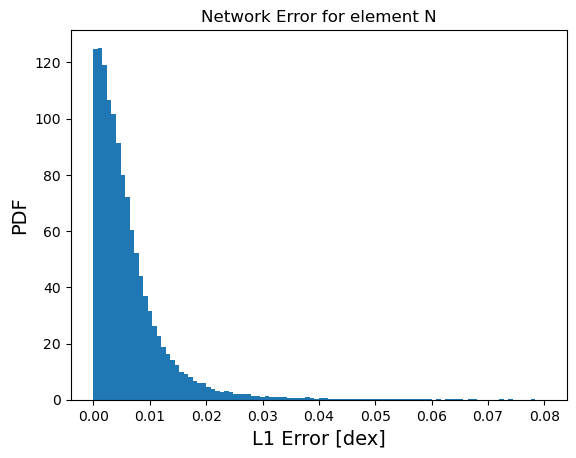

In [50]:
l1_err = np.abs(stacked_net_output(sq_testX)-testY)*ab_std # must remember to rescale by abundance standardizations

element_index = 4
plt.hist(l1_err[:,element_index],range=[0,.08],bins=100,density=True);
plt.xlabel(r'L1 Error [dex]',fontsize=14)
plt.ylabel(r'PDF',fontsize=14);
plt.title(r'Network Error for element %s'%els[element_index]);

In [51]:
p1,p2,p3=np.percentile(l1_err,[15.865,50.,100-17.865],axis=0).mean(axis=1)

In [52]:
print(r'L1 error (averaged across elements) is %.3f-%.3f+%.3f'%(p2,p2-p1,p3-p2))

L1 error (averaged across elements) is 0.005-0.004+0.008


We can also assess the full convergence across parameter space via the same mean L1 error, as a corner plot;

In [53]:
train_par = cut_params3
test_par=cut_params3T
stacked_pred =stacked_net_output(sq_testX)
stacked_diff = np.mean(np.abs((stacked_pred-testY)*ab_std),axis=1) # destandardize here

<Figure size 640x480 with 0 Axes>

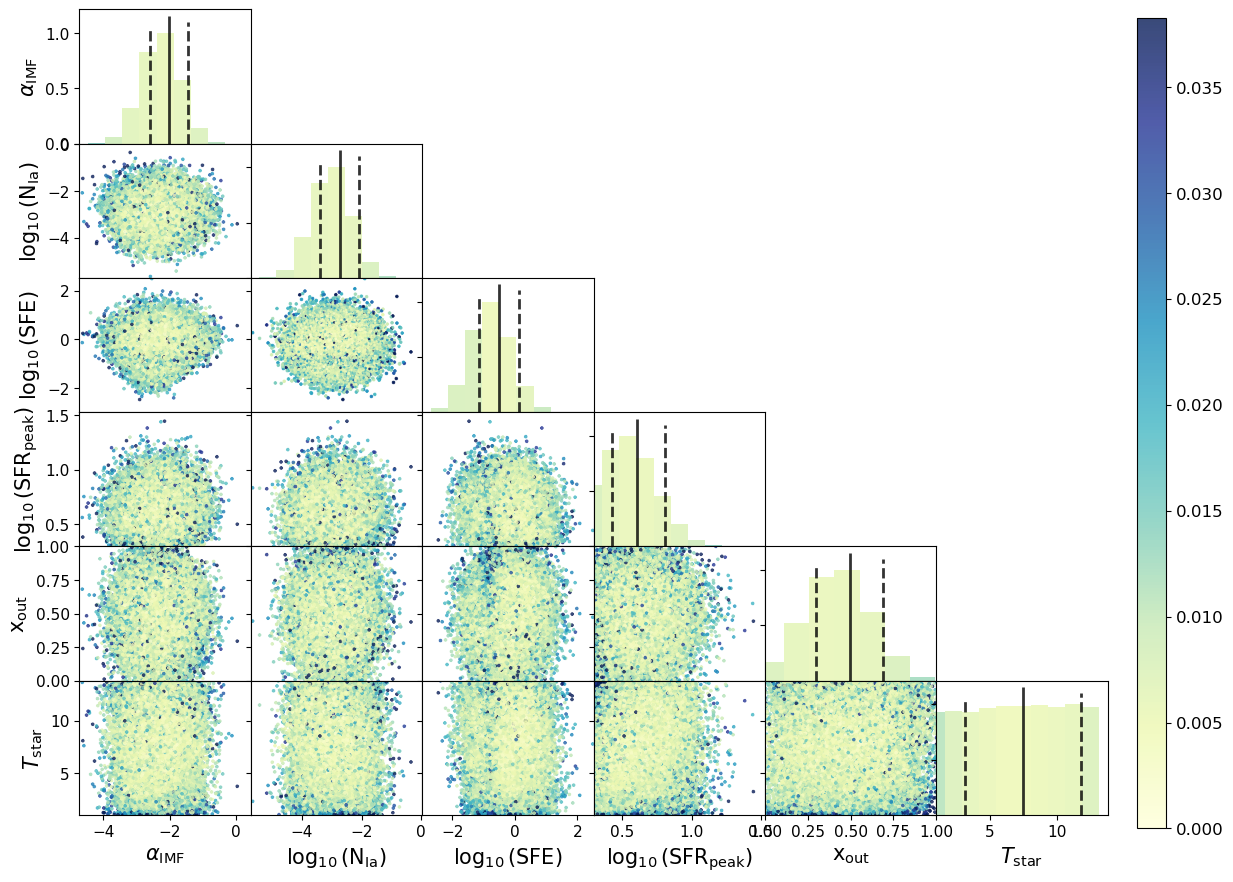

In [54]:
data_tr = train_par
data_v = test_par
param_error = stacked_diff

# Initialize plot
plt.clf()
text_size = 12

parameter_names = [r'$\alpha_\mathrm{IMF}$',r'$\log_{10}(\mathrm{N_{Ia}})$',
               r'$\log_{10}(\mathrm{SFE})$',
               r'$\log_{10}(\mathrm{SFR_{peak}})$',r'$\mathrm{x}_\mathrm{out}$',r'$T_\mathrm{star}$']

# Plot settings
fig,axes = plt.subplots(nrows = 6, ncols = 6,figsize=(14.69,9.0))#,dpi=300)
alpha = 0.8
lw=2 # Linewidth
left = 0.1 # Left side of subplots
right = 0.8 # Right side
bottom = 0.075
top = 0.97
wspace = 0.0 # blankspace width between subplots
hspace = 0.0 # blankspace height between subplots
color_max = np.percentile(param_error,99.)#0.05#a.color_max
plt.subplots_adjust(left=left,bottom=bottom,right=right,top=top,wspace=wspace,hspace=hspace)

cmap= cm.YlGnBu

# Create plot
for i in range(6):
    for j in range(6):
        axes[i,j].locator_params(nbins=4)
        axes[i,j].xaxis.set_tick_params(labelsize=11)
        axes[i,j].yaxis.set_tick_params(labelsize=11)
        if j==1:
            axes[i,j].locator_params(nbins=4)
        if i==j:
            counts,edges = np.histogram(np.asarray(data_v[:,j]),bins=10)
            max_count = float(np.max(counts))
            counts = np.divide(counts,max_count)
            median = np.zeros(len(edges)-1)
            for k in range(len(edges)-1):
                choice = np.logical_and(np.greater(data_v[:,j],edges[k]),np.less(data_v[:,j],edges[k+1]))
                error=np.extract(choice,param_error)
                if len(error) != 0:
                    median[k] = np.median(error)
            colors = cmap(median/color_max)
            axes[i,j].bar(x = edges[:-1], height=counts, width = edges[1]-edges[0],
                                color=colors,alpha=alpha, linewidth=0,rasterized=True)
            axes[i,j].set_xlim(min(data_v[:,j]),max(data_v[:,j]))
            if j==4:
                axes[i,j].set_xlim(0,1)
            if j !=0:
                plt.setp(axes[i,j].get_yticklabels(), visible=False)
            axes[i,j].vlines(np.percentile(data_v[:,j],15.865),axes[i,j].get_ylim()[0],axes[i,j].get_ylim()[1], color = 'k',alpha=alpha,linewidth = lw,linestyle = 'dashed')
            axes[i,j].vlines(np.percentile(data_v[:,j],100-15.865),axes[i,j].get_ylim()[0],axes[i,j].get_ylim()[1], color = 'k',alpha=alpha,linewidth = lw,linestyle = 'dashed')
            axes[i,j].vlines(np.percentile(data_v[:,j],50),axes[i,j].get_ylim()[0],axes[i,j].get_ylim()[1], color = 'k',alpha=alpha,linewidth = lw)
        if i>j:
            if j !=0:
                plt.setp(axes[i,j].get_yticklabels(), visible=False)
            P1 = axes[i,j].scatter(data_v[:,j],data_v[:,i],marker='x',alpha=alpha,
                                    c=param_error,vmin=0,vmax=color_max,cmap=cmap,s=3,rasterized=True)
            axes[i,j].set_xlim(min(data_tr[:,j]),max(data_tr[:,j]))
            axes[i,j].set_ylim(min(data_tr[:,i]),max(data_tr[:,i]))
            if j==4:
                axes[i,j].set_xlim(0,1)
            if i==4:
                axes[i,j].set_ylim(0,1)
        if j>i:
            axes[i,j].axis('off')
        if i == 5:
            axes[i,j].set_xlabel(parameter_names[j],fontsize=15)
        if j ==0:
            axes[i,j].set_ylabel(parameter_names[i],fontsize=15)
        if i==2 and j == 1:
            cplot = axes[i,j].scatter(data_v[:,j],data_v[:,i],marker='.',alpha=alpha,
                                                c=param_error,vmin=0,vmax=color_max,
                                                cmap=cmap,s=3,rasterized=True)
            axes[i,j].set_xlim(min(data_tr[:,j]),max(data_tr[:,j]))
            axes[i,j].set_ylim(min(data_tr[:,i]),max(data_tr[:,i]))
cax=fig.add_axes([0.82,0.06,0.02,0.9]);
cbar=plt.colorbar(cplot,cax=cax);
cbar.ax.tick_params(labelsize=12)

plt.show();


This completes the neural network training.

In [72]:
stacked_net_output(sq_testX[0])-testY[0]

array([ 0.02741323, -0.00154376, -0.02686761,  0.00589023, -0.00105703,
        0.00652373,  0.04190665,  0.0597143 ])

In [71]:
testY[0]

array([-0.35292223,  0.0852684 , -0.17060443, -0.01758689,  0.1857489 ,
        0.00757151, -0.11856669, -0.32074683])

# 3) Creation of Mock Data and Formatting Observational Data

Here we present the code required to create a mock data-set using *Chempy*. This is identical to the routines used to create the mock data in the *ChempyMulti* paper for both TNG and Alternative yields. At the end of the section we will describe the data-model used for the mock data, since real observational data can be substituted for this.

First we choose some SSP values. Here we'll set them to the TNG values;

In [55]:
global_params = np.asarray([-2.3,-2.89])

Now we generate a set of random parameter draws from the priors for the ISM parameters. Here we'll create 1100 draws, to give a full data-set of $\sim 1000$ stars after cuts have been made later. Here we draw the times from a uniform distribution with $T_i\in[2,12.8]\,$Gyr to ensure times are separated from the edges of the neural network training data.

In [56]:
# Generate random stellar datapoints with these global parameters
N_stars = 1100
times = np.random.uniform(2.,12.8,N_stars)

# Minimum SFR constraint (see Philcox + Rybizki 2019 paper)
log_SFR_lim = 0.29402

# Load ISM priors and widths
ism_priors = a.p0[2:]
ism_prior_widths = [0.3,0.1,0.1]

# Create random draws from these priors
ism_params = [np.random.normal(loc=ism_priors[i],scale=ism_prior_widths[i],size=N_stars) for i in range(len(ism_priors))]
ism_params = np.asarray(ism_params).T.reshape(N_stars,len(ism_priors))

# Redraw the SFR parameter from a truncated normal prior to satisfy log10(SFR)>0.29402 condition for well-behaved SFRs
from scipy.stats import truncnorm
ism_params[:,1]=truncnorm.rvs((log_SFR_lim-ism_priors[1])/ism_prior_widths[1],np.inf,
                              loc=ism_priors[1],scale=ism_prior_widths[1],size=N_stars)

# Assemble full parameter vectors for input into single_timestep_chempy()
full_params = np.zeros([len(ism_params),6])
for i in range(len(full_params)):
    full_params[i]=np.asarray(list(global_params)+list(ism_params[i])+[times[i]])

Next we'll run the ``single_timestep_chempy()`` function once to check all is well and to set the list of elements.

In [115]:
# Now fix relevant elements by running Chempy
out=np.inf
i=0
while out==np.inf:
    out=single_timestep_chempy((full_params[i],a))
    i+=1
_,chempy_els=out


We're now ready to run the inference. The next step will create output abundances from each of the 1100 input parameter vectors created above. This is done with the default parameters in the ``Chempy/parameter.py`` file (or those in the input ``ModelParameters()`` class). Here we'll create data with the TNG yield set. To save time, we'll run the *Chempy* simulations in parallel using Python's ``multiprocessing`` module.

In [118]:
## Check we're using the correct yields:
assert a.yield_table_name_1a == 'TNG'
assert a.yield_table_name_sn2 == 'TNG_net'
assert a.yield_table_name_agb == 'TNG_net'

def runner(index):
    """Function to compute the Chempy predictions for each input parameter set.
    Index specifies which set of parameters to use, from the full_params array."""
    b=ModelParameters()
    output=single_timestep_chempy((full_params[index],b))
    if type(output)==float:
        if output==np.inf:
            del b
        outs=np.zeros(len(chempy_els))
    else: 
        abun=output[0]
        del b;
        outs=abun
    return outs


In [119]:
# Now run the inference in parallel
import multiprocessing as mp
import tqdm
p=mp.Pool()
mock_abundances=np.asarray(list(tqdm.tqdm(p.imap(runner,range(len(full_params))),total=len(full_params))))

100%|██████████| 1100/1100 [00:35<00:00, 30.77it/s]


It took around 30s to run all the calculations in parallel, giving a set of 1100 output abundance vectors. Next we'll reorder these into the order specified in the ``ModelParameters()`` class (under the ``initial_neural_names`` vector, which is the same as used by the neural net. We'll also filter out any instances where *Chempy* failed to return proper output abundances (due to internal assumptions being broken by this parameter set). 

In [124]:
mock_ordered_abundances = np.zeros([len(mock_abundances),len(a.initial_neural_names)])        
for i,el in enumerate(a.initial_neural_names):
    for j,el_chempy in enumerate(chempy_els):
        if str(el)==str(chempy_els[j]):
            mock_ordered_abundances[:,i]=mock_abundances[:,j]
            break
        if j==len(chempy_els)-1:
            print('Element %s not found'%el)
        
# Ensure there's no bad values in the dataset.
good_id=np.where(mock_ordered_abundances[:,0]!=0)
true_abundances=mock_ordered_abundances[good_id]
true_times=times[good_id]
full_params2=full_params[good_id]

print("%d out of %d sets of parameters were faulty and have been removed"%(len(full_params)-len(full_params2),len(full_params)))

0 out of 1100 sets of parameters were faulty and have been removed


We now add observational errors to the abundances and stellar birth-times. This is done by drawing observed values from Gaussian distributions with means at the true values and 20% (5%) standard deviations for the birth-time (abundances). Birth times and abundances are rounded to 2 decimal places, and we note that the *absolute* error in the [X/Fe] and [Fe/H] abundances is 0.05, since they are logarithmic quantities.

We filter out any birth-times below 1 Gyr or above 13.8 Gyr for ease of fitting. This could similarly be done with real observational data.

In [125]:
from scipy.stats import norm

# Define observational erorrs
pc_ab = 5 # percentage error in abundance
pc_time = 20 # percentage error in birth-time (= percentage error in age)

# Jitter true abundances and birth-times by these errors to create mock observational values.
obs_ab_errors = np.ones_like(true_abundances)*float(pc_ab)/100.
obs_abundances = norm.rvs(loc=true_abundances,scale=obs_ab_errors).round(2)
obs_time_errors = (np.abs(true_times)*float(pc_time)/100.).round(2)
obs_times = norm.rvs(loc=true_times,scale=obs_time_errors).round(2)

# Now filter to remove bad input times
filt = np.where((obs_times>1.)&(obs_times<13.8))
obs_ab_errors=obs_ab_errors[filt]
obs_abundances=obs_abundances[filt]
obs_time_errors=obs_time_errors[filt]
obs_times=obs_times[filt]
true_times = true_times[filt]
true_abundances = true_abundances[filt]

print("We are left with %d stellar data-points."%len(true_abundances))

We are left with 1054 stellar data-points.


Now save the output data.

In [126]:
np.savez('/home/oliverphilcox/ChempyMulti/tutorial_data/Tutorial_Mock_Data.npz',
         elements = np.asarray(a.initial_neural_names,dtype=str),
         abundances = obs_abundances, abundance_errs = obs_ab_errors,
         true_time = true_times, obs_time = obs_times, obs_time_err = obs_time_errors,
         true_abuns = true_abundances)

**Data Model**

Mock data-sets are saved as ``.npz`` files with the columns listed below. These are automatically read by the inference routines. To infer obsevational data, we simply need to replace the mock data-set with an observational data-set of the same format. 

- ``elements``: Element symbols for which abundances are provided. This should be an array or list of length $n_\mathrm{el}$ and should not include any normalizing elements (e.g. 'H', since [H/Fe] and [Fe/H] abundances are degenerate).
- ``abundances``: Observed chemical elements abundances at the time of stellar birth in dex. **NB:** For observational abundances, these must be proto-stellar abundances, i.e. corrected for any post-birth changes. This should be an array of shape $(n_\mathrm{stars},n_\mathrm{el})$.
- ``abundance_errs``: Observational error in chemical element abundance in dex. This should be an array of shape $(n_\mathrm{stars},n_\mathrm{el})$
- ``obs_time``: Observated (or inferred) estimate of the stellar birth-time in Gyr. This should be filtered to avoid birth-times below $1\,$Gyr or above $13.8\,$Gyr. This is used as the mean of the prior birth-time distribution. This should be an array of length $n_\mathrm{stars}$.
- ``obs_time_err``: Observational error on the stellar birth-time estimate in Gyr. This is used as the width of the prior birth-time distribution. This should be an array of length $n_\mathrm{stars}$.
- ``true_abuns``: (*Optional*) True stellar chemical element abundance in dex. This is not used by the inference routines. This should be an array of shape $(n_\mathrm{stars},n_\mathrm{el})$.
- ``true_time``: (*Optional*) True stellar birth-time in Gyr. This is not used by the inference routines. This should be an array of length $n_\mathrm{stars}$.

**Mock Datasets**

The mock data-sets used in the *ChempyMulti* analysis (Philcox & Rybizki 2019) have been made publicly available. They can be found in the ``tutorial_data`` directory in the same format as above. We provide three mock data-sets:
    
1. Mock data created with *Chempy* using IllustrisTNG yields: ``tutorial_data/Mock_Data_Chempy+TNG.npz``
2. Mock data created with *Chempy* using Alternative yields (see paper): ``tutorial_data/Mock_Data_Chempy+Alternative.npz``
3. Mock data drawn from the [IllustrisTNG] TNG100-1 simulation (from halo 523071): ``tutorial_data/Mock_Data_TNG.npz``

All data-sets use SSP parameters of $\alpha_\mathrm{IMF} = -2.3$ and $\log_{10}(N_\mathrm{Ia}) = -2.89$, with $20\%$ errors in birth-time and $0.05\,$dex errors in abundance. For each data-set, there are $\sim 1000$ objects, with the first $200$ being used in the main *ChempyMulti* paper analyses. We do not provide the entire set of ($\sim 40,000$) stellar particles from the IllustrisTNG halo; these are available upon request.

# 4) Parameter Inference using PyMC3
We are now ready to infer the SSP (as well as ISM and birth-time) parameters with Hamiltonian Monte Carlo (HMC) inference using the data-set created above. For this we will use the [PyMC3](https://docs.pymc.io/) code which contains many useful tools for sampling via HMC and other methods. An introduction to HMC is presented in the *ChempyMulti* paper.

For convenience, we have defined our sampling routines in a separate script; ``run_pymc3.py``. This takes an input neural network (in the format created above) as well as observational data and runs HMC inference for an input set of data-set sizes (i.e. values of $n_\mathrm{stars}$). The basic outline of the script is as follows:
1. Load the neural network weights and observational data and standardize using the neural network standardization parameters.
2. Create a PyMC3 model object from the neural network and free parameters. This uses the default SSP and ISM priors in the *ChempyMulti* paper, but can be easily modified. The model is defined in the [theano](http://deeplearning.net/software/theano/) language, which allows it to be automatically differentiated.
3. Inference is run using the No U-Turn Algorithm to perform HMC sampling for all required sub-sample sizes.
4. Data is reconstructed and output to a user-specified `.npz` file.

This script is run as follows:

    python run_pymc3.py sampling_options/tutorial_options.txt
    
In the ``sampling_options/tutorial_options.txt`` file we give all relevant inputs to the function. An example options file is shown below:

    [input]
    neural_model: /home/oliverphilcox/ChempyMulti/tutorial_data/TNG_Network_Weights.npz
    mock_data_file: /home/oliverphilcox/ChempyMulti/tutorial_data/Tutorial_Mock_Data.npz
    outfile: /home/oliverphilcox/ChempyMulti/tutorial_data/Inference_Output.npz

    [inference]
    all_n: [1,2,5,10]
    elem_err: True 
    max_iteration: 10
    
    [sampler]
    chains: 16
    cores: 16
    tune: 2000
    n_init: 10000
    n_samples: 1000
   
These parameters are described below:
- `neural_model`: Location of the input neural network weights, as created in step 2 above.
- `mock_data_file`: Location of the input mock or observational data, as created in step 3 above.
- `outfile`: Desired output file. **NB**: This may be a large file depending on the number of stars and samples chosen.
-`all_n`: List of $n_\mathrm{stars}$ values (i.e. number of stars to analyze) to use in the inference. In the list above, we will run analyses for 1, 2, 5 and 10 stars. Using $n_\mathrm{stars}$ up to $\sim 200$ gives reasonable computation times.
-`elem_err`: Boolean, whether to use the model errors in the inference, as defined in the *ChempyMulti* paper. This should usually be switched on to allow for discrepancies between the data and the *Chempy* model.
- `max_iteration`: Maximum number of stars to use in the analysis. In the above example, setting this to 10 means we will compute 10 1-star inferences, 5 2-star inferences, 2 5-star inferences and 1 10-star inference.
- `chains`: Number of Markov chains to run. Using one chain per CPU core is most efficient, but we should use at least 4 chains to avoid errors.
- ``cores``: Number of CPU cores on which to run. The code will use the maximum number of cores available if there are more requested than available.
- ``tune``: The number of tuning (a.k.a. 'burn-in') steps used in each Markov chain. These are needed to ensure that NUTS is sampling the correct posterior.
- ``n_init``: The number of ADVI steps used to initialize the HMC sampler, and give a simple estimate of the posterior. Values around 10000 generally work well.
- ``n_samples``: Number of samples in each HMC chain. In the output, all chains are added together, to give $n_\mathrm{chains}n_\mathrm{samples}$ total posterior function samples.

Using the above sampling options, the code took $\sim 20$ minutes to run on a set of modern CPU-cores.


# 5) Analysis of the HMC Posterior Chains
Now we have run the HMC inference, we can analyze the output posterior distributions.

First we'll load the data;

In [205]:
dat = np.load('/home/oliverphilcox/ChempyMulti/tutorial_data/Inference_Output.npz')

This has the following keys:
- `n_stars`: Value of $n_\mathrm{stars}$ for each inference run.
- `Lambdas`: Output posterior chains for the global SSP parameters $\vec\Lambda = \{\alpha_\mathrm{IMF},\log_{10}(N_\mathrm{Ia})\}$. This is a list of lists of arrays for each value of $n_\mathrm{stars}$ and sub-sample. Each array (for an individual PyMC3 run) has shape $(n_\mathrm{chains}n_\mathrm{samples},2)$. The $i$-th estimate of the $j$-th $\vec\Lambda$ value for the $k$-th realization at the $l$-th $n_\mathrm{stars}$ value is indexed as ``Lambdas[l][k][i,j]``, e.g. we can extract the entire posterior chain for $\log_{10}(N_\mathrm{Ia})$ (the second value in $\vec\Lambda$) for the third realization of the first value of $n_\mathrm{stars}$ as ``Lambdas[0][2][:,1]``
- `Errors`: Output posterior chains for the model-error parameters $\Sigma = \{\sigma_\mathrm{model}^j\}$. This is a list of list of arrays as above, with each array having shape $(n_\mathrm{chains}n_\mathrm{samples},n_\mathrm{el})$. The $i$-th estimate of the $j$-th element model error for the $k$-th realization of the $l$-th $n_\mathrm{stars}$ value is indexed as ``Errors[l][k][i,j]``, e.g. we can extract the entire posterior chain for the sixth element for the third realization of the first value of $n_\mathrm{stars}$ as ``Errors[0][2][:,5]``
- `Thetas`: Output posterior chains for the local ISM parameters $\vec\Theta_i = \{\log_{10}(\rm{SFE}), \log_{10}(\rm{SFR_{peak}}),\rm{x_{out}}\}_i$. This is a list of list of arrays as above. For a given realization number and $n_\mathrm{stars}$ value, the array has shape $(n_\mathrm{chains}n_\mathrm{samples},n_\mathrm{stars},2)$. The $i$-th estimate of the $j$-th $\vec\Theta$ value **in the $m$-th star** for the $k$-th realization at the $l$-th $n_\mathrm{stars}$ value is indexed as ``Thetas[l][k][i,m,j]``, e.g. we can extract the entire posterior chain for the fourth-star value of $\rm{x}_\mathrm{out}$ (the third value in $\vec\Theta$) for the second realization of the third value of $n_\mathrm{stars}$ as ``Lambdas[2][1][:,3,2]``
- `Times`: Output posterior chains for the stellar birth-times $T$. This is a list of list of arrays as before, with each array having shape $(n_\rm{chains}n_\rm{samples},n_\rm{stars})$. The $i$-th estimate of the $T$ value in the $m$-th star for the $k$-th realization at the $l$-th $n_\mathrm{stars}$ value is indexed as ``Times[l][k][i,m]``, e.g. we can extract the entire posterior chain for the fourth-star birth-time for the second realization of the third value of $n_\mathrm{stars}$ as ``Times[2][1][:,3]``
- `runtimes`: Runtimes in seconds for each individual inference run. This is list of lists, as above, with the runtime of the $k$-th realization of the $l$-th $n_\mathrm{stars}$ value accessed as ``runtimes[l][k]``.
- `mean_runtimes`: Mean runtimes in seconds for each $n_\mathrm{stars}$ value, averaged across all realizations. This is an array of length $n_\mathrm{stars}$.

Let's plot the dependence of the global parameter estimates on $n_\mathrm{stars}$ as in the *ChempyMulti* paper. This includes both the sample (from the choice of data-set) and statistical (from the HMC posterior distribution widths) variances.

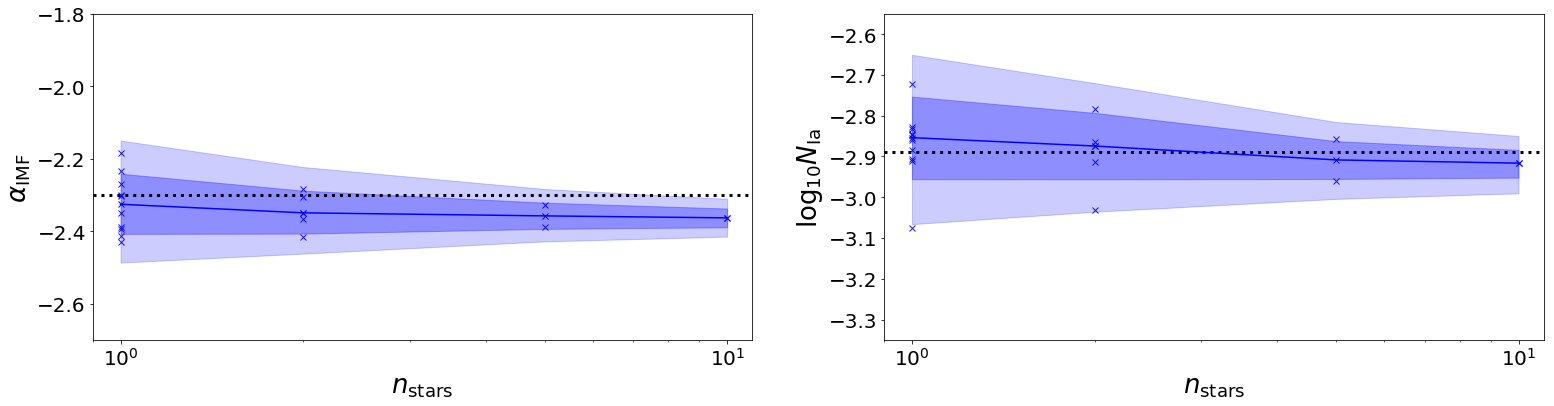

In [206]:
labels=[r'$\alpha_\mathrm{IMF}$',r'$\log_{10}N_\mathrm{Ia}$'] # Names of the global Lambda parameters
true = [-2.3,-2.89] # true values of parameters from input simulations

fig,ax=plt.subplots(nrows=1,ncols=2,figsize=(26,6));

# Extract the lambda values and n-stars
all_Lambdas = dat.f.Lambdas
n_stars = dat.f.n_stars

# Here we compute the statistical variances, averaged across realizations with the same value of n-stars
med,lo,up,lo2,up2,sample_lo,sample_hi=[np.zeros((len(n_stars),2)) for _ in range(7)]
for i in range(len(n_stars)):
    # Select only the Lambda estimates for this value of n-stars
    theseL=all_Lambdas[i]
    # Now compute the median, 1- and 2-sigma parameter ranges from the output chains for each realization using this n-stars.
    lowL2,lowL,medianL,upL,upL2 = [[np.percentile(L,p,axis=0) for L in theseL] for p in [2.275,15.865,50.,84.135,97.725]]
    # Take the average over all realizations
    up[i]=np.median(upL,axis=0)
    lo[i]=np.median(lowL,axis=0)
    up2[i]=np.median(upL2,axis=0)
    lo2[i]=np.median(lowL2,axis=0)
    med[i]=np.median(medianL,axis=0)
    
FS=22 # set the fontsize
vmin,vmax=0.9,11 # set x-axis limits

# Now plot the results
for ind in [0,1]:
    ax[ind].set_xscale('log')
    
    # Plot the median estimates and the 1- and 2-sigma regions averaged across realizations
    ax[ind].errorbar(n_stars,med[:,ind],yerr=0.,marker='x',c='b')
    ax[ind].fill_between(n_stars,lo[:,ind],up[:,ind],alpha=0.3,color='b')
    ax[ind].fill_between(n_stars,lo2[:,ind],up2[:,ind],alpha=0.2,color='b')

    # Plot the individual median parameter estimates from each realization to show sample variance
    for i in range(len(n_stars)):
        for j in range(len(all_Lambdas[i])):
            ax[ind].errorbar(n_stars[i],np.median(all_Lambdas[i][j],axis=0)[ind],marker='x',c='b',alpha=0.9)

    # Plot true values from simulations
    ax[ind].hlines(true[ind],vmin,vmax,linestyles=':',lw=3)
    
    # Now add axis labels
    ax[ind].set_ylabel(labels[ind],fontsize=FS+4)    
    ax[ind].set_xlabel(r'$n_\mathrm{stars}$',fontsize=FS+4)
    ax[ind].set_xscale('log');
    for label in (ax[ind].get_xticklabels()+ax[ind].get_yticklabels()):
        label.set_fontsize(fontsize=FS-2)
    ax[ind].set_xlim([vmin,vmax]);

ax[0].set_ylim([-2.7,-1.8])

ax[1].set_ylim([-3.35,-2.55]);

Here the individual data-points show median estimates from each realization at fixed $n_\mathrm{stars}$. The solid line shows the medians averaged across realizations with the dark (light) shaded regions showing the average $1\sigma$ ($2\sigma$) statistical deviation (i.e. posterior distribution width) in each inference. The dotted line shows the true values used in Step 3 above.

The full results from the parameter inferences using $n_\mathrm{stars}$ up to $200$ for the three mock data-sets used in the *ChempyMulti* paper are large data-files, but can be made available upon request.

Now let's plot the element errors as in the paper plot. We'll specify to $n_\mathrm{stars}=5$ here.

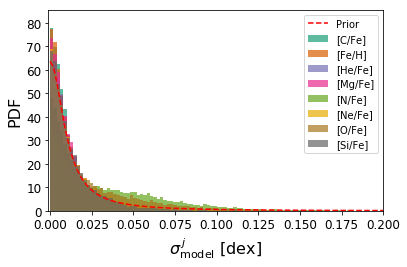

In [207]:
# First load the element errors
all_Errs=dat.f.Errors

# Pick out the index with n-stars=5
n_index = np.where(n_stars==5)[0][0]
these_Errs=all_Errs[n_index][0]

els = ['C','Fe','He','Mg','N','Ne','O','Si'] # TNG elements
x_max = 0.2 # maximum x-axis value

# Generate the prior PDF for the element errors
from scipy.stats import halfcauchy
xx = np.linspace(0,x_max,100)
yy = halfcauchy.pdf(xx,scale=0.01)

# Define the output element names
names = []
for el in els:
    if el!='Fe':
        names.append('[%s/Fe]'%el)
    else:
        names.append('[Fe/H]')

# Plot the figure
plt.figure(figsize=(6,3.7))
all_x=[]
# Iterate over elements
for el in range(8):
    col = plt.cm.Dark2(el/8)
    # Create histograms for each element
    x,y,_=plt.hist(these_Errs[:,el],bins=100,alpha=0.7,range=[0,x_max],color=col,density=True,label=names[el]);
    loc = np.argmax(x)
    all_x.append(x)
# Plot the priors
plt.plot(xx,yy,c='r',ls='--',label=r'Prior')
plt.xlim([-0.001,x_max])
plt.ylim([0,np.concatenate(all_x).max()*1.1]);
plt.legend();
for label in (plt.gca().get_xticklabels()+plt.gca().get_yticklabels()):
        label.set_fontsize(fontsize=12)

plt.ylabel(r'PDF',fontsize=16)
plt.xlabel(r'$\sigma_\mathrm{model}^{\,j}$ [dex]',fontsize=16);

Here all the model errors seem to just be reproducing the priors, which is expected, since they were generated and analyzed with the same physical model (*Chempy* with TNG yields).

Finally, let's plot the mean and variance of the sampling runtimes as a function of $n_\mathrm{stars}$.

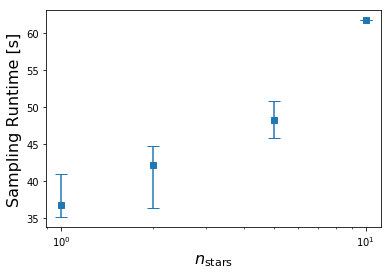

In [210]:
# First load the run-times
all_runtimes = dat.f.runtimes

# Compute median and 1sigma runtimes;
med_runtimes = np.asarray([np.median(these_runtimes) for these_runtimes in all_runtimes])
hi_runtimes = np.asarray([np.percentile(these_runtimes,15.865) for these_runtimes in all_runtimes])
lo_runtimes = np.asarray([np.percentile(these_runtimes,100.-15.65) for these_runtimes in all_runtimes])

plt.errorbar(n_stars,med_runtimes,yerr=[med_runtimes-lo_runtimes,hi_runtimes-med_runtimes],ls='',capsize=6,marker='s')
plt.ylabel(r'Sampling Runtime [s]',fontsize=16)
plt.xlabel(r'$n_\mathrm{stars}$',fontsize=16);
plt.xscale('log');

**This completes the tutorial. For any questions regarding running *ChempyMulti* please contact [Oliver Philcox](ohep2@alumni.cam.ac.uk) or [Jan Rybizki](rybizki@mpia.de).**